# IBM Data Science- Applied Data Science Capstone - Week 3
## Part 1: Read Data and Formatting
**First Step**: Import all the necessary libraries



In [2]:
!pip install html5lib
!pip install lxml
!pip install beautifulSoup4

import pandas as pd
import numpy as np
import html5lib
import lxml
from bs4 import BeautifulSoup

     |████████████████████████████████| 5.8MB 6.6MB/s eta 0:00:01     |████████▋                       | 1.5MB 6.6MB/s eta 0:00:01     |█████████████                   | 2.3MB 6.6MB/s eta 0:00:01
     |████████████████████████████████| 112kB 5.0MB/s eta 0:00:01


**Second Step**: Download the table as a list from wikipedia and convert in a dataframe

In [3]:
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
#Download as a list
canada = pd.read_html(link,flavor='html5lib')
canada[0]

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
...,...,...,...
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...


In [4]:
#Convert in a dataframe
df_canada= pd.DataFrame(canada[0]) 
df_canada.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


**Third Step**: Data formatting:
* Remove the rows with Borough value equals to "Not Assigned"
* Replace slash by comma in Neighborhood column
* Check if there are rows with no value or similar


In [5]:
#Remove the rows with Borough "Not Assigned" 
df_canada= df_canada[df_canada['Borough'] != "Not assigned"]
#Reset the index
df_canada.reset_index(drop=True, inplace=True)
df_canada.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [6]:
#Replace slash by comma
df_canada = df_canada.replace({'/': ','}, regex=True)
df_canada.head()

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"


In [7]:
#Check if there is Neighborhood with Not assigned or empty
df_canada[(df_canada['Neighborhood'] == "Not assigned")&(df_canada['Neighborhood'] == "")]

,Postal code,Borough,Neighborhood


In [8]:
#Shape of the final dataframe
df_canada.shape

(103, 3)

## Part 2: Add Latitude and Longitude for each Borough

In [9]:
#As I am not able to use geocoder.google cause it is running indefinitely, I will use the file
csv_path='https://cocl.us/Geospatial_data'
df_coordinates=pd.read_csv(csv_path) 
df_coordinates.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
#Create a new dataframe with the columns latitude and longitude. Rename the column PostalCode is necessary in order to have the same name for both dataframes
column_names = ['PostalCode','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
df_canada.rename(columns={"Postal code": "PostalCode"},inplace=True)
df_coordinates.rename(columns={"Postal Code": "PostalCode"},inplace=True)
df_neighborhoods= pd.merge(df_canada,df_coordinates,on="PostalCode")
df_neighborhoods.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## Part 3: Clustering

In [23]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

In [24]:
#Latitude and Longitude of Toronto

address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Map with the current dataframe with all the postal codes

In [210]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_neighborhoods['Latitude'], df_neighborhoods['Longitude'], df_neighborhoods['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

We are not interested in the neighborhoods without Toronto in the name due to the problem statement: the displacement is between West Toronto and Toronto East. So the possible neighborhoods will be West Toronto, North Toronto, MidTown Toronto, Downtown Toronto, and Toronto East. Also, I am going to mix the column PostalCode with Borough in order to work with that column
![alt text](https://github.com/PFCid/Coursera_Capstone/blob/master/Problem.jpg?raw=true "Problem Statement")

In [57]:
df_toronto=df_neighborhoods[df_neighborhoods['Borough'].str.find("Toronto") != -1]
df_toronto["PostalCode"]=df_toronto["PostalCode"].astype(str)+" ("+df_toronto["Borough"].astype(str) +")"
df_toronto.drop(["Borough"],axis=1,inplace=True)
df_toronto.reset_index(drop=True, inplace=True)
df_toronto.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PostalCode,Neighborhood,Latitude,Longitude
0,M5A (Downtown Toronto),"Regent Park , Harbourfront",43.654260,-79.360636
1,M7A (Downtown Toronto),"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
2,M5B (Downtown Toronto),"Garden District, Ryerson",43.657162,-79.378937
3,M5C (Downtown Toronto),St. James Town,43.651494,-79.375418
4,M4E (East Toronto),The Beaches,43.676357,-79.293031


Load necessary libraries and values for Foursquare API Management

In [41]:
import requests # library to handle requests
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library

In [38]:
CLIENT_ID = 'REMOVED' # your Foursquare ID
CLIENT_SECRET = 'REMOVED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius


Function to explore neighborhoods

In [164]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [165]:
# type your answer here

toronto_venues = getNearbyVenues(names=df_toronto['PostalCode'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

M5A (Downtown Toronto)
M7A (Downtown Toronto)
M5B (Downtown Toronto)
M5C (Downtown Toronto)
M4E (East Toronto)
M5E (Downtown Toronto)
M5G (Downtown Toronto)
M6G (Downtown Toronto)
M5H (Downtown Toronto)
M6H (West Toronto)
M5J (Downtown Toronto)
M6J (West Toronto)
M4K (East Toronto)
M5K (Downtown Toronto)
M6K (West Toronto)
M4L (East Toronto)
M5L (Downtown Toronto)
M4M (East Toronto)
M4N (Central Toronto)
M5N (Central Toronto)
M4P (Central Toronto)
M5P (Central Toronto)
M6P (West Toronto)
M4R (Central Toronto)
M5R (Central Toronto)
M6R (West Toronto)
M4S (Central Toronto)
M5S (Downtown Toronto)
M6S (West Toronto)
M4T (Central Toronto)
M5T (Downtown Toronto)
M4V (Central Toronto)
M5V (Downtown Toronto)
M4W (Downtown Toronto)
M5W (Downtown Toronto)
M4X (Downtown Toronto)
M5X (Downtown Toronto)
M4Y (Downtown Toronto)
M7Y (East Toronto)


In [166]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 231 uniques categories.


In [167]:
toronto_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A (Downtown Toronto),43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A (Downtown Toronto),43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A (Downtown Toronto),43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A (Downtown Toronto),43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A (Downtown Toronto),43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


Obtain a dataframe with the mean of the frequency per each venue

In [169]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 
cols = list(toronto_onehot.columns.values) #Make a list of all of the columns in the toronto_onehot
cols.pop(cols.index('PostalCode')) #Remove Neighborhood from list
toronto_onehot = toronto_onehot[['PostalCode']+cols] #Create new dataframe with columns in the order you want
toronto_onehot.head()

,PostalCode,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M5A (Downtown Toronto),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A (Downtown Toronto),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A (Downtown Toronto),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A (Downtown Toronto),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A (Downtown Toronto),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I am going to remove all the venues which for me are not interesting to decide the best neighborhood

In [77]:
#List of all the categories
cols

['Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Workshop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Stadium',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Belgian Restaurant',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Butcher',
 'Café',
 'Cajun / Creole Restaurant',
 'Candy Store',
 'Caribbean Restaurant',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Climbing Gym',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'College Arts Building',
 'College Auditorium',
 'College Gym',
 'College Rec Cen

In [170]:
remaining_col=['PostalCode','Airport', 'Antique Shop', 'Aquarium', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant', 'Athletics & Sports', 'Auto Workshop', 'BBQ Joint', 'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Basketball Stadium', 'Beach',
  'Beer Bar', 'Beer Store', 'Belgian Restaurant', 'Bistro', 'Board Shop', 'Boat or Ferry', 'Bookstore', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Bubble Tea Shop','Building', 'Burger Joint', 'Burrito Place', 'Bus Line', 'Butcher', 
  'Café', 'Cajun / Creole Restaurant', 'Candy Store', 'Caribbean Restaurant', 'Cheese Shop', 'Chinese Restaurant', 'Chocolate Shop','Church', 'Climbing Gym', 'Clothing Store', 'Cocktail Bar', 'Coffee Shop', 'College Arts Building', 'College Auditorium', 'Colombian Restaurant', 'Comfort Food Restaurant',
  'Comic Shop', 'Concert Hall', 'Convenience Store', 'Costume Shop', 'Creperie', 'Cuban Restaurant', 'Cupcake Shop', 'Dance Studio', 'Deli / Bodega', 'Department Store','Dessert Shop', 'Diner', 'Discount Store', 
  'Doner Restaurant', 'Donut Shop', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Electronics Store', 'Ethiopian Restaurant', 'Event Space', 'Falafel Restaurant', 'Farmers Market', 'Fast Food Restaurant', 'Filipino Restaurant', 
  'Fish & Chips Shop', 'Fish Market', 'Flea Market', 'Food', 'Food & Drink Shop', 'Food Court', 'Food Truck', 'Fountain', 'French Restaurant', 'Fried Chicken Joint', 'Frozen Yogurt Shop', 'Fruit & Vegetable Store', 'Furniture / Home Store', 
  'Garden', 'Garden Center', 'Gas Station', 'Gastropub', 'General Entertainment', 'General Travel', 'German Restaurant', 'Gluten-free Restaurant', 'Gourmet Shop', 'Greek Restaurant', 'Grocery Store', 'Gym', 'Gym / Fitness Center', 
   'Health Food Store','Historic Site', 'History Museum', 'Hospital', 'IT Services', 'Ice Cream Shop', 'Indian Restaurant', 'Indie Movie Theater', 'Irish Pub', 'Italian Restaurant', 'Japanese Restaurant', 'Jazz Club', 'Jewelry Store', 'Juice Bar', 
  'Knitting Store', 'Korean Restaurant', 'Lake', 'Latin American Restaurant', 'Light Rail Station', 'Liquor Store', 'Lounge', 'Market', 'Martial Arts Dojo', 'Mediterranean Restaurant', "Men's Store", 'Mexican Restaurant', 
  'Middle Eastern Restaurant', 'Miscellaneous Shop', 'Modern European Restaurant', 'Molecular Gastronomy Restaurant', 'Monument / Landmark', 'Moroccan Restaurant', 'Movie Theater', 'Museum', 'Music Venue', 'New American Restaurant', 
  'Nightclub', 'Noodle House', 'Office', 'Opera House', 'Optical Shop', 'Organic Grocery', 'Other Great Outdoors', 'Outdoor Sculpture', 'Park', 'Performing Arts Venue', 'Pet Store', 'Pharmacy', 'Pizza Place', 'Plane', 'Playground', 
  'Plaza', 'Poke Place', 'Pool', 'Portuguese Restaurant', 'Poutine Place', 'Pub', 'Ramen Restaurant', 'Record Shop', 'Rental Car Location', 'Restaurant', 'Roof Deck', 'Sake Bar', 'Salad Place', 'Salon / Barbershop', 'Sandwich Place', 
  'Scenic Lookout', 'Sculpture Garden', 'Seafood Restaurant', 'Shoe Store', 'Shopping Mall', 'Smoke Shop', 'Soup Place', 'South American Restaurant', 'Spa', 'Speakeasy', 'Sporting Goods Shop', 'Sports Bar', 'Stadium', 'Stationery Store', 
  'Steakhouse', 'Supermarket', 'Sushi Restaurant', 'Taco Place', 'Tailor Shop', 'Taiwanese Restaurant', 'Tea Room', 'Thai Restaurant', 'Theater', 'Theme Restaurant', 'Trail', 'Train Station', 'Vegetarian / Vegan Restaurant',
  'Vietnamese Restaurant', 'Wine Bar']
toronto_onehot_filt=toronto_onehot[remaining_col]
#Drop the rows which are empty due to the removal of the columns
toronto_onehot_filt=toronto_onehot_filt[toronto_onehot_filt.sum(axis=1)!=0]

In [199]:
#Dataframe with the mean of the frequencies per Neighborhood
toronto_grouped = toronto_onehot_filt.groupby('PostalCode').mean().reset_index()
toronto_grouped.head()

,PostalCode,Airport,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,M4E (East Toronto),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.250,0.0,0.0,0.0,0.000000
1,M4K (East Toronto),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.025,0.0,0.0,0.0,0.000000
2,M4L (East Toronto),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000
3,M4M (East Toronto),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.029412,0.0,0.0,0.000,0.0,0.0,0.0,0.029412
4,M4N (Central Toronto),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000000


In [184]:
#Check if the sum of all the columns is equals to one, in order to ensure that frequency has been correctly calculated
toronto_grouped.sum(axis=1)

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
35    1.0
36    1.0
37    1.0
38    1.0
dtype: float64

Clustering with K-means

In [192]:
from sklearn.cluster import KMeans 
#Normalizing over the standard deviation
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

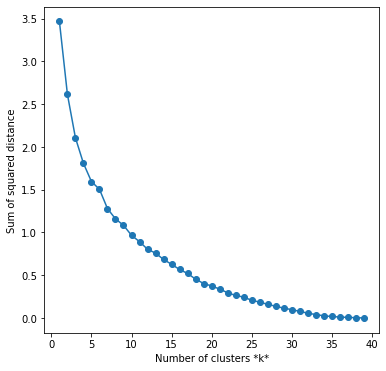

In [196]:
#Select the correct k having in mind the inertia for each K
sse = []
list_k = list(range(1, 40))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(toronto_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

With the values represented above, a good compromise for K would be 9, where the curve starts to be more flattened 

In [197]:
kclusters = 9

toronto_grouped_clustering=toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 2, 2, 2, 4, 7, 2, 2, 6, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 1, 2, 2, 2, 8, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2], dtype=int32)

In [200]:
# add clustering labels
toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [201]:
toronto_merged = df_toronto

# merge to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_grouped.set_index('PostalCode'), on='PostalCode')
toronto_merged.head()

,PostalCode,Neighborhood,Latitude,Longitude,Cluster Labels,Airport,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,M5A (Downtown Toronto),"Regent Park , Harbourfront",43.654260,-79.360636,2,0.0,0.02381,0.0,0.023810,0.0,...,0.0,0.000000,0.000000,0.047619,0.0,0.00,0.0,0.000000,0.000000,0.000000
1,M7A (Downtown Toronto),"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,2,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.028571,0.0,0.00,0.0,0.000000,0.000000,0.000000
2,M5B (Downtown Toronto),"Garden District, Ryerson",43.657162,-79.378937,2,0.0,0.00000,0.0,0.011236,0.0,...,0.0,0.022472,0.011236,0.022472,0.0,0.00,0.0,0.000000,0.011236,0.000000
3,M5C (Downtown Toronto),St. James Town,43.651494,-79.375418,2,0.0,0.00000,0.0,0.013699,0.0,...,0.0,0.000000,0.013699,0.027397,0.0,0.00,0.0,0.013699,0.000000,0.013699
4,M4E (East Toronto),The Beaches,43.676357,-79.293031,0,0.0,0.00000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.25,0.0,0.000000,0.000000,0.000000


In [208]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see, some of the clusters are really isolated compared with other ones (for example, cluster 8 with the airport). So in the next steps these clusters will be checked in order to understand if they should be removed from the possible options. 